In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

In [3]:
NEO4J_URL = os.getenv('NEO4J_URL')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

## Graph Visualization Tool

In [4]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from netgraph import Graph as ngGraph


def display_graph():
    # Neo4j connection configuration
    url = NEO4J_URL
    user = NEO4J_USERNAME
    password = NEO4J_PASSWORD

    # Connect to Neo4j
    driver = GraphDatabase.driver(url, auth=(user, password))

    # Updated query to return node names
    query = """
    MATCH (n)
    OPTIONAL MATCH (n)-[r]->(m)
    RETURN n.name AS source_name, type(r) AS relationship_type, m.name AS target_name
    """

    # Function to execute the query and process results
    def get_graph_data(tx):
        result = tx.run(query)
        nodes = set()
        edges = []
        for record in result:
            source_name = record["source_name"]
            target_name = record["target_name"]
            relationship = record["relationship_type"]

            if source_name:
                nodes.add(source_name)
            if target_name:
                nodes.add(target_name)
                edges.append((source_name, target_name, relationship))

        return list(nodes), edges

    # Execute the query and get results
    with driver.session() as session:
        nodes, edges = session.execute_read(get_graph_data)

    # Create a NetworkX directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from([(source, target, {'type': rel_type}) for source, target, rel_type in edges])

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 12))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Use netgraph for layout and drawing
    try:
        plot_instance = ngGraph(G, node_layout='spring', node_size=5, node_color='lightblue',
                        edge_width=0.4, edge_alpha=1, edge_color='black',
                        node_labels=True, edge_labels=nx.get_edge_attributes(G, 'type'),
                        arrows=True, ax=ax, arrowsize=1,
                        edge_arrow_width=0.5,
                        node_label_fontdict={'size': 12})
    except:
        plt.clf()
        plt.close(fig)
        ax.clear()
        plt.close('all')
        return "Nothing to Plot, add memories"

    plt.title("Mem0 Graph Memory Visualization", fontsize=20)

    # Enable zoom and pan
    def zoom_factory(ax, base_scale=2.):
        def zoom_fun(event):
            cur_xlim = ax.get_xlim()
            cur_ylim = ax.get_ylim()
            xdata = event.xdata
            ydata = event.ydata
            if event.button == 'up':
                scale_factor = 1/base_scale
            elif event.button == 'down':
                scale_factor = base_scale
            else:
                scale_factor = 1
            new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
            new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor
            relx = (cur_xlim[1] - xdata)/(cur_xlim[1] - cur_xlim[0])
            rely = (cur_ylim[1] - ydata)/(cur_ylim[1] - cur_ylim[0])
            ax.set_xlim([xdata - new_width * (1-relx), xdata + new_width * (relx)])
            ax.set_ylim([ydata - new_height * (1-rely), ydata + new_height * (rely)])
            plt.draw()
        fig = ax.get_figure()
        fig.canvas.mpl_connect('scroll_event', zoom_fun)
        return zoom_fun

    zoom = zoom_factory(ax)

    def on_press(event):
        if event.inaxes != ax: return
        ax._pan_start = (event.x, event.y)

    def on_release(event):
        if event.inaxes != ax: return
        ax._pan_start = None

    def on_motion(event):
        if event.inaxes != ax: return
        if not ax._pan_start: return
        dx = event.x - ax._pan_start[0]
        dy = event.y - ax._pan_start[1]
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        scale_x = (xlim[1] - xlim[0]) / ax.get_window_extent().width
        scale_y = (ylim[1] - ylim[0]) / ax.get_window_extent().height
        ax.set_xlim(xlim - dx * scale_x)
        ax.set_ylim(ylim + dy * scale_y)
        ax._pan_start = (event.x, event.y)
        plt.draw()

    fig.canvas.mpl_connect('button_press_event', on_press)
    fig.canvas.mpl_connect('button_release_event', on_release)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)

    plt.show()

    # Close the driver connection
    driver.close()

## Initializing the mem0's memory client with config

In [5]:
from mem0 import Memory

config = {
    "embedder": {
        "provider": "gemini",
        "config": {
            # Provider-specific settings go here - https://docs.mem0.ai/components/embedders/config
            "model": "embedding-001",
            "embedding_dims":768
        }
    },
    "llm": {
        "provider": "gemini",
        "config": {
            # Provider-specific settings go here - https://docs.mem0.ai/components/llms/config
            "model": "gemini-2.0-flash",
            "temperature": 0
        }
    },
    "graph_store": {
        "provider": "neo4j",
        "config": {
            "url": NEO4J_URL,
            "username": NEO4J_USERNAME,
            "password": NEO4J_PASSWORD
        }
    },
    "version": "v1.1"
}

m = Memory.from_config(config_dict=config)

user_id = "alice123"

/home/pc/Documents/repo/mem0/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clear Graph (OPTIONAL)

In [6]:
m.delete_all(user_id=user_id)

{'message': 'Memories deleted successfully!'}

## ADD Memory

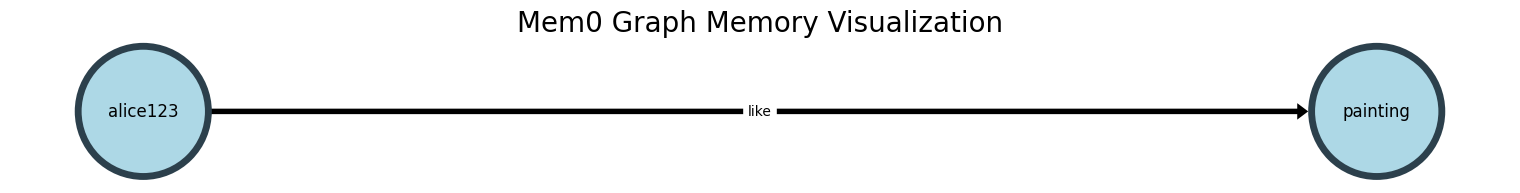

({'results': [{'id': '5c264c2e-46bd-4566-9486-fb8629a73465',
    'memory': 'Likes painting',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'alice123',
      'relationship': 'like',
      'target': 'painting'}]]}},
 None)

In [7]:
m.add("I like painting", user_id=user_id), display_graph()

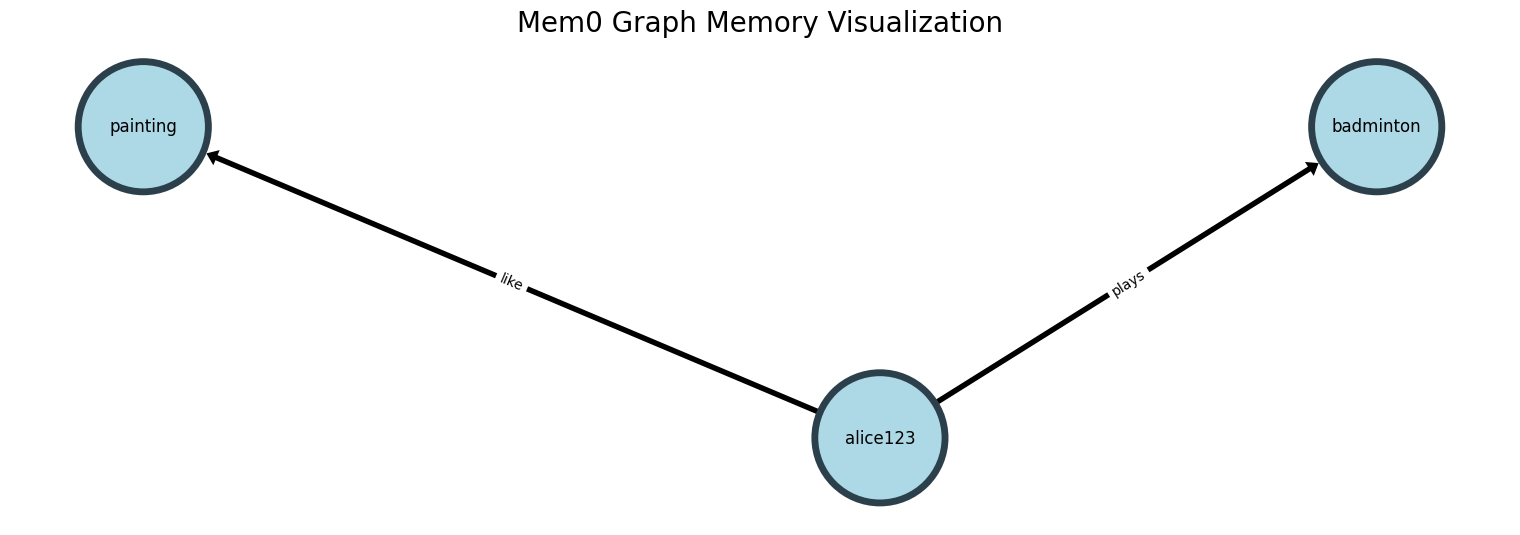

({'results': [{'id': '01634f16-8a4a-4e5c-b0da-3674903a6c69',
    'memory': 'Loves to play badminton',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'alice123',
      'relationship': 'plays',
      'target': 'badminton'}]]}},
 None)

In [8]:
m.add("I love to play badminton", user_id=user_id), display_graph()

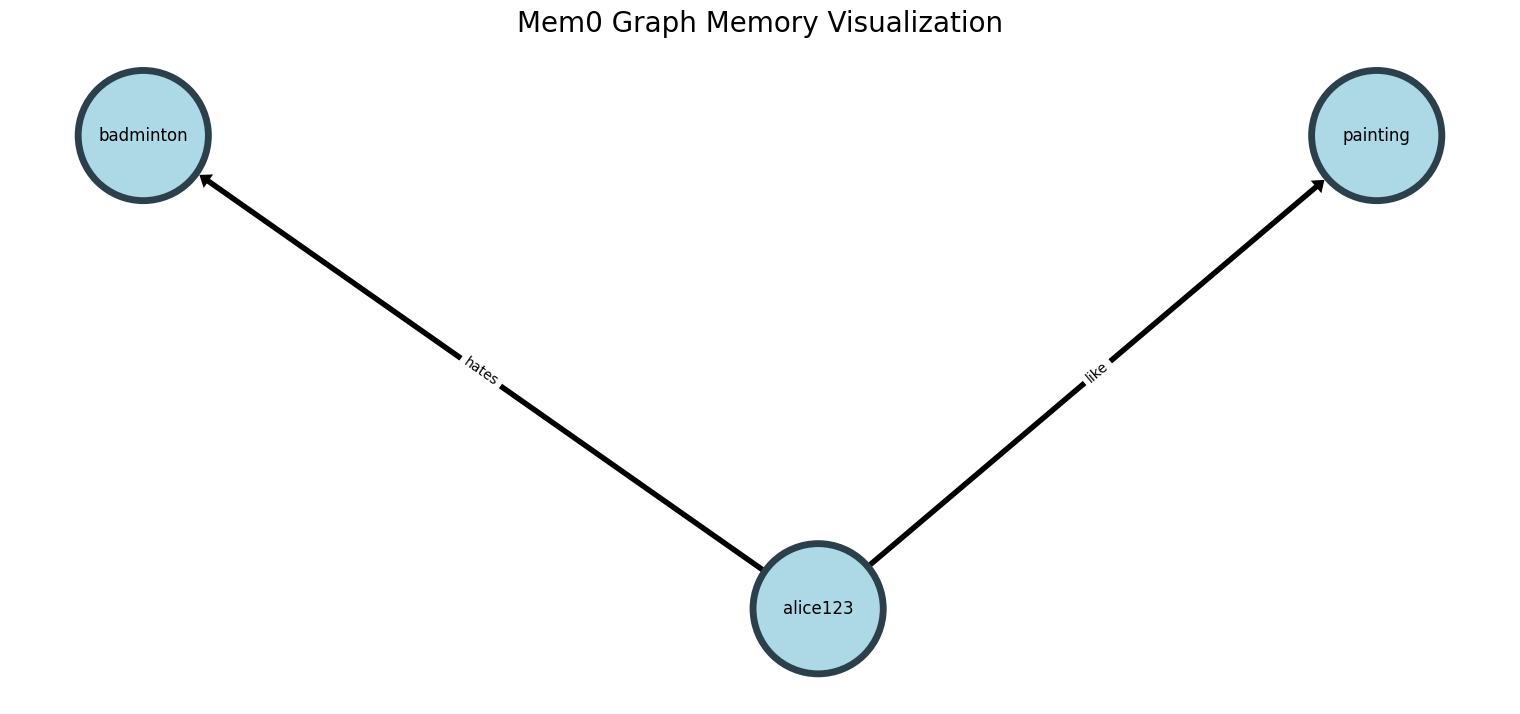

({'results': [{'id': '01634f16-8a4a-4e5c-b0da-3674903a6c69',
    'memory': 'Loves to play badminton',
    'event': 'DELETE'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'alice123',
      'relationship': 'hates',
      'target': 'badminton'}]]}},
 None)

In [9]:
m.add("I hate playing badminton", user_id=user_id), display_graph()

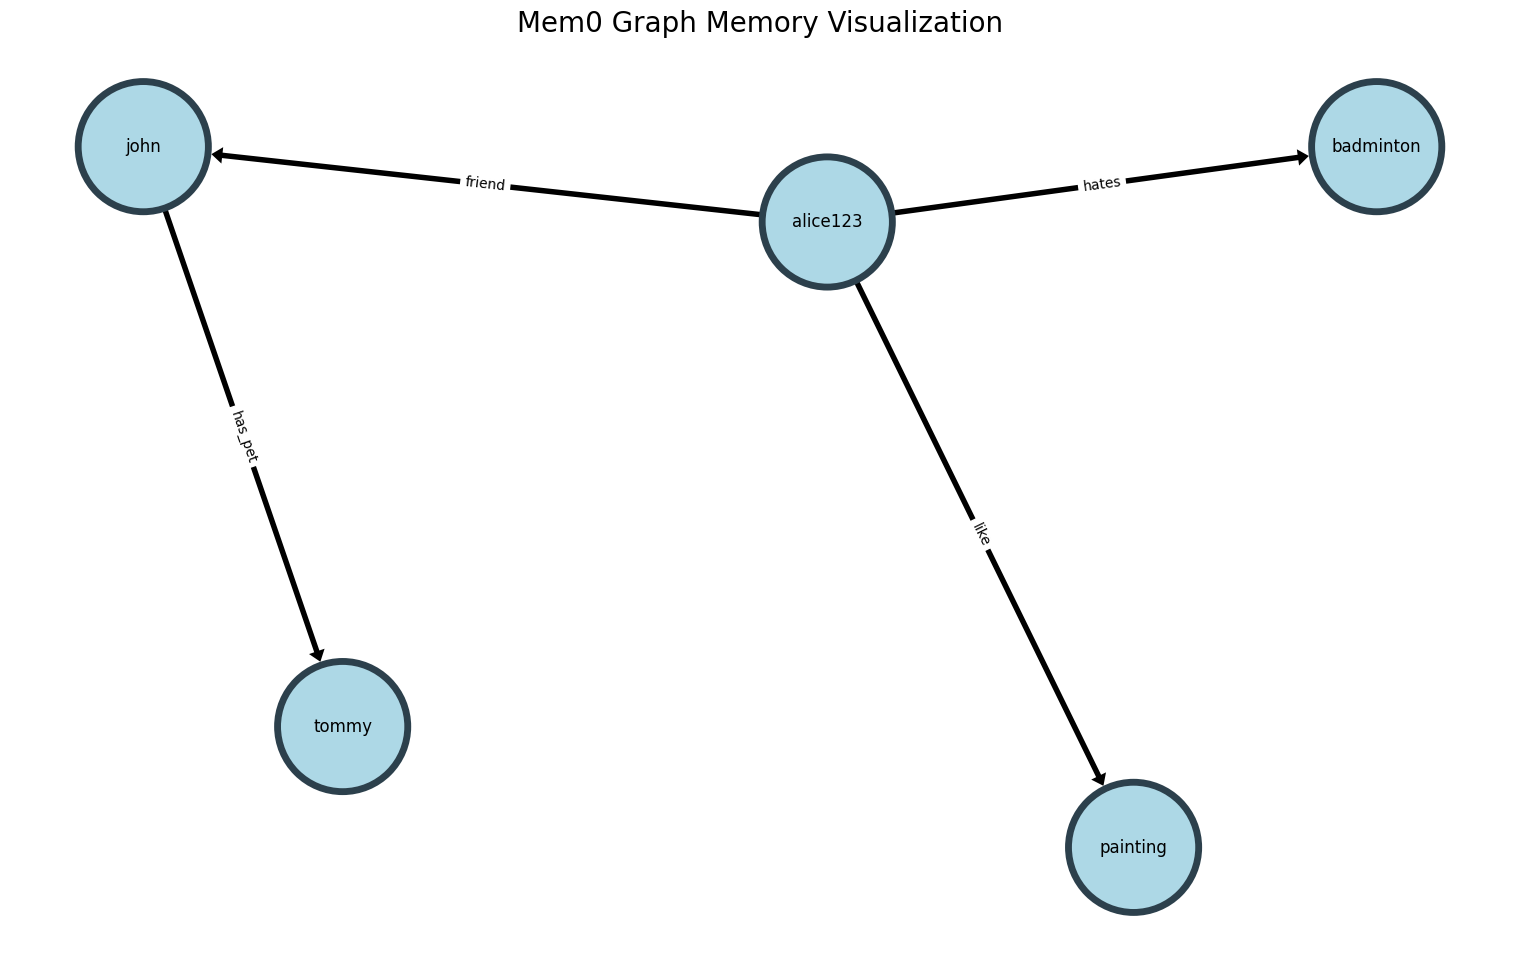

({'results': [{'id': '8fd86780-282d-4fb7-b3ca-edb285b1b4d6',
    'memory': "Friend's name is John",
    'event': 'ADD'},
   {'id': 'f15f51f4-290b-41c8-893a-ece07568b26b',
    'memory': 'John has a dog named Tommy',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'alice123',
      'relationship': 'friend',
      'target': 'john'}],
    [{'source': 'john', 'relationship': 'has_pet', 'target': 'tommy'}]]}},
 None)

In [11]:
m.add("My friend name is john and john has a dog named tommy", user_id=user_id), display_graph()

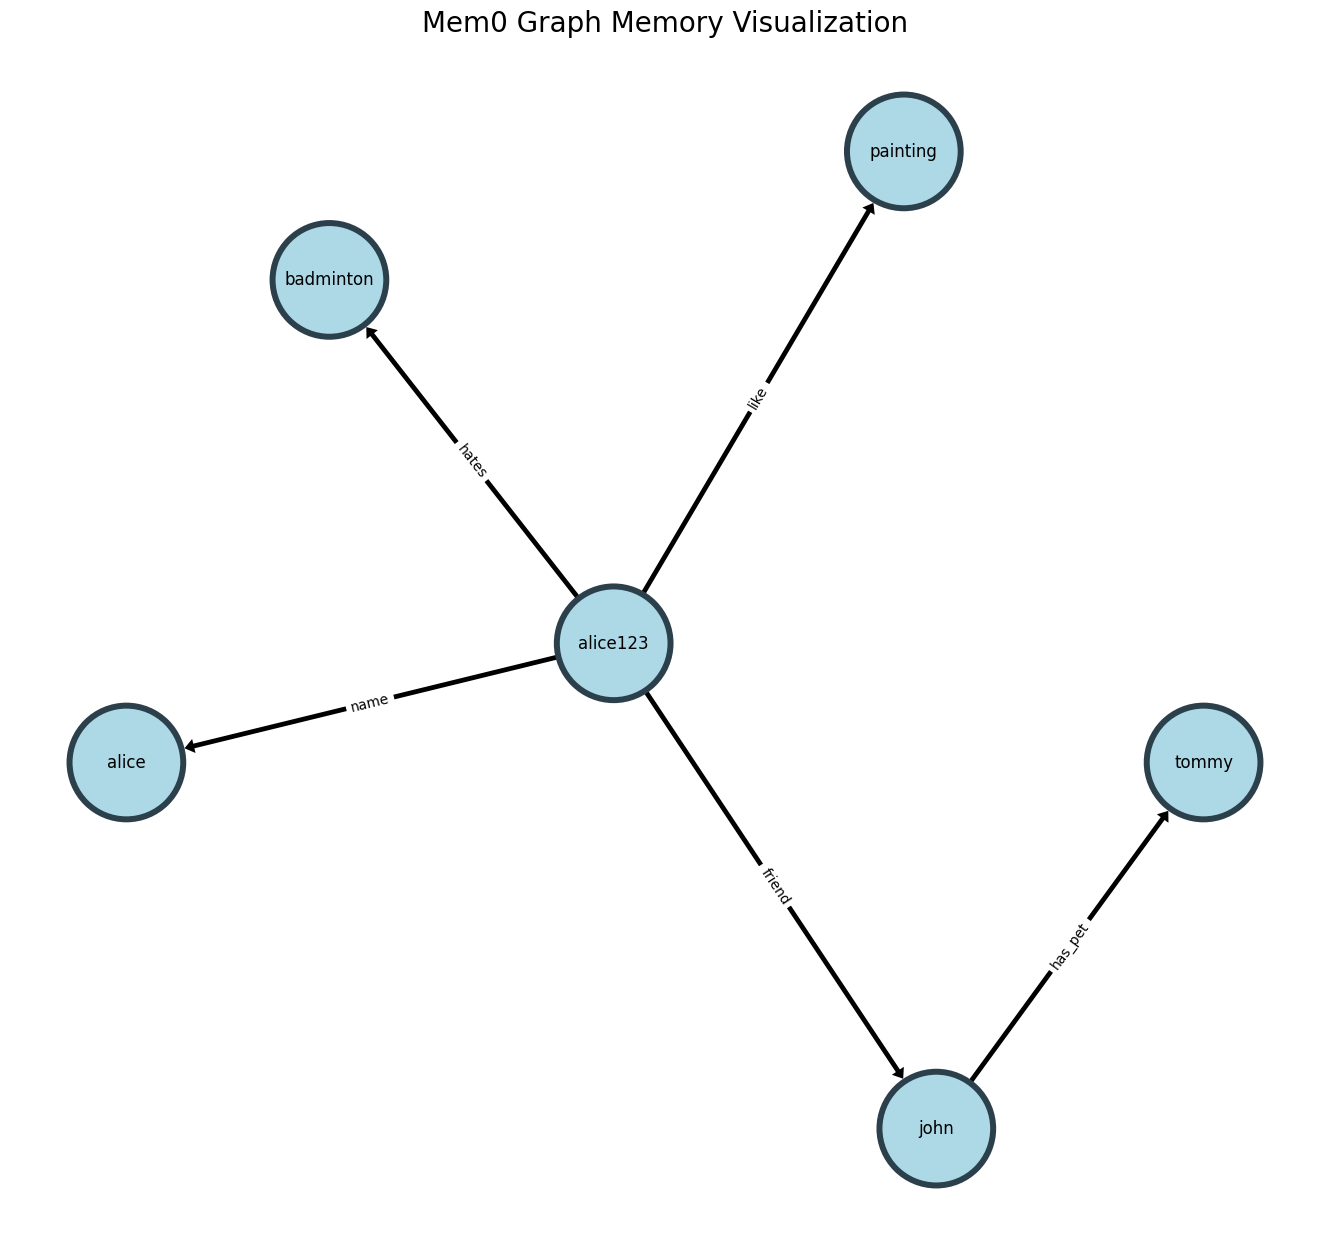

({'results': [{'id': 'e976f4f7-74b7-4c6e-8df3-52da16b167f3',
    'memory': 'Name is alice',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'alice123',
      'relationship': 'name',
      'target': 'alice'}]]}},
 None)

In [12]:
m.add("My name is alice", user_id=user_id), display_graph()

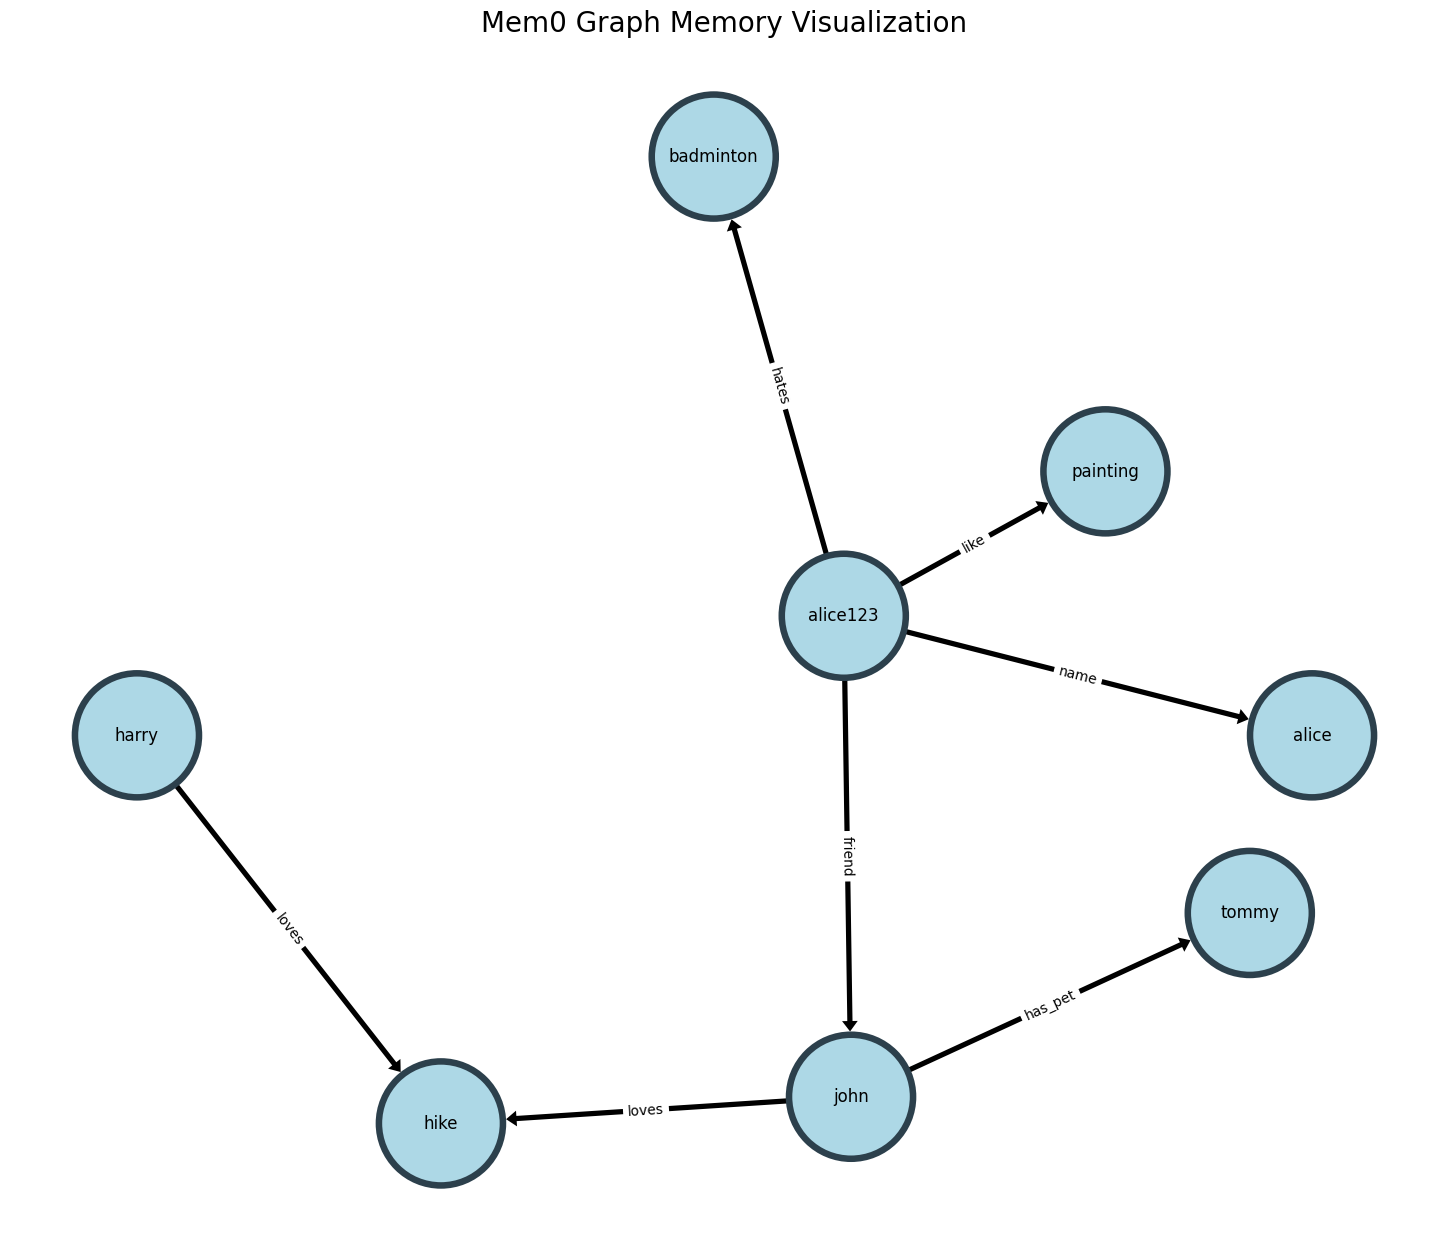

({'results': [{'id': 'e6eedd38-d60f-4248-a79c-b8b2ef914bb9',
    'memory': 'John loves to hike',
    'event': 'ADD'},
   {'id': 'c9385853-b6d9-406f-a5df-f190866a4bd5',
    'memory': 'Harry loves to hike',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'john',
      'relationship': 'loves',
      'target': 'hike'}],
    [{'source': 'harry', 'relationship': 'loves', 'target': 'hike'}]]}},
 None)

In [13]:
m.add("John loves to hike and Harry loves to hike as well", user_id=user_id), display_graph()

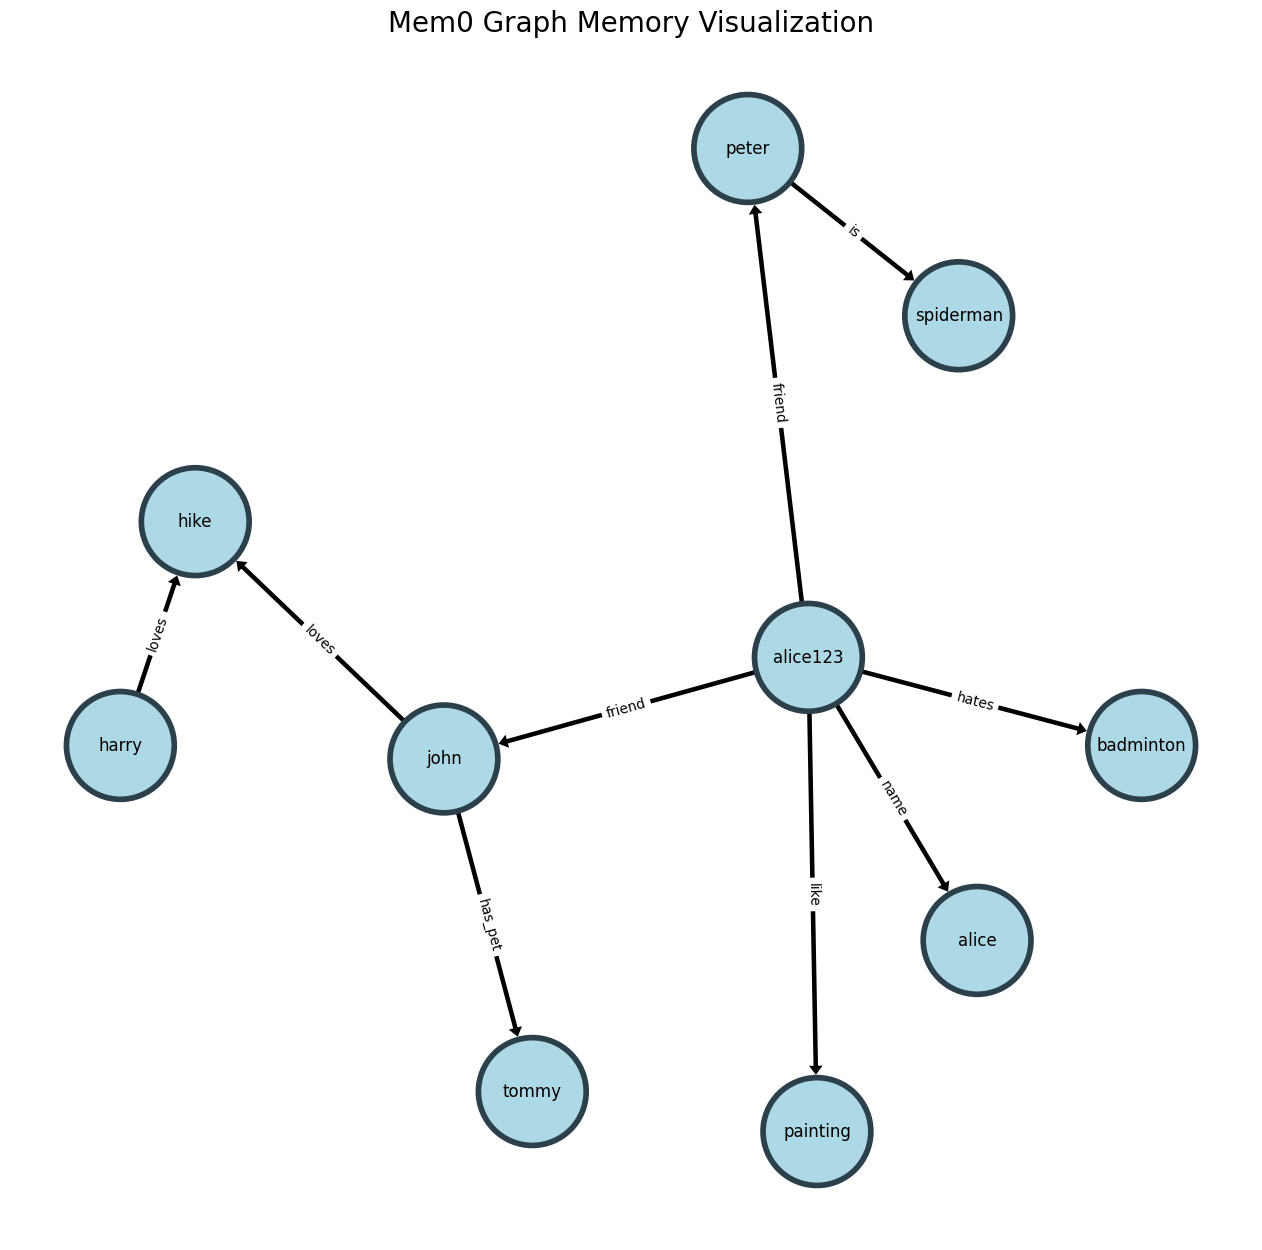

({'results': [{'id': '23fbb218-07bd-4086-bde3-930d693e9a37',
    'memory': 'Friend Peter is the Spiderman',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'alice123',
      'relationship': 'friend',
      'target': 'peter'}],
    [{'source': 'peter', 'relationship': 'is', 'target': 'spiderman'}]]}},
 None)

In [14]:
m.add("My friend peter is the spiderman", user_id=user_id), display_graph()

## Get all memories from Graph Memory

In [15]:
m.get_all(user_id=user_id)

{'results': [{'id': '23fbb218-07bd-4086-bde3-930d693e9a37',
   'memory': 'Friend Peter is the Spiderman',
   'hash': '997d6297108ba97808320c86fbc8d2c3',
   'metadata': None,
   'created_at': '2025-06-12T03:47:12.942903-07:00',
   'updated_at': None,
   'user_id': 'alice123'},
  {'id': '5c264c2e-46bd-4566-9486-fb8629a73465',
   'memory': 'Likes painting',
   'hash': '8fc874722a8eb7df25eaba02c88fc030',
   'metadata': None,
   'created_at': '2025-06-12T03:45:31.003979-07:00',
   'updated_at': None,
   'user_id': 'alice123'},
  {'id': '8fd86780-282d-4fb7-b3ca-edb285b1b4d6',
   'memory': "Friend's name is John",
   'hash': '26787975c6a8668ff45d0d9ebd482b39',
   'metadata': None,
   'created_at': '2025-06-12T03:46:45.940401-07:00',
   'updated_at': None,
   'user_id': 'alice123'},
  {'id': 'c9385853-b6d9-406f-a5df-f190866a4bd5',
   'memory': 'Harry loves to hike',
   'hash': '2a2e80ab0b83e4f2ebec8456712ed23d',
   'metadata': None,
   'created_at': '2025-06-12T03:47:06.393777-07:00',
   'upda

## SEARCH in Graph Memory

In [16]:
m.search("Who is spiderman?", user_id=user_id)

{'results': [{'id': '23fbb218-07bd-4086-bde3-930d693e9a37',
   'memory': 'Friend Peter is the Spiderman',
   'hash': '997d6297108ba97808320c86fbc8d2c3',
   'metadata': None,
   'score': 0.8207379396814717,
   'created_at': '2025-06-12T03:47:12.942903-07:00',
   'updated_at': None,
   'user_id': 'alice123'},
  {'id': 'e976f4f7-74b7-4c6e-8df3-52da16b167f3',
   'memory': 'Name is alice',
   'hash': 'e07fb07f6eb87aabbe53f5469aa6e00a',
   'metadata': None,
   'score': 0.6385627576915511,
   'created_at': '2025-06-12T03:46:56.376279-07:00',
   'updated_at': None,
   'user_id': 'alice123'},
  {'id': '5c264c2e-46bd-4566-9486-fb8629a73465',
   'memory': 'Likes painting',
   'hash': '8fc874722a8eb7df25eaba02c88fc030',
   'metadata': None,
   'score': 0.5815717556181224,
   'created_at': '2025-06-12T03:45:31.003979-07:00',
   'updated_at': None,
   'user_id': 'alice123'},
  {'id': '8fd86780-282d-4fb7-b3ca-edb285b1b4d6',
   'memory': "Friend's name is John",
   'hash': '26787975c6a8668ff45d0d9ebd4